In [ ]:
# source: http://outlace.com/Reinforcement-Learning-Part-1/

In [14]:
#imports, nothing to see here
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
n = 10
arms = np.random.rand(n)
eps = 0.1

In [12]:
arms

array([ 0.34756088,  0.20978724,  0.46639625,  0.95012392,  0.86400292,
        0.60269145,  0.99418775,  0.54476422,  0.65451508,  0.32653485])

In [16]:
def reward(prob):
    reward = 0;
    for i in range(10):
        if random.random() < prob:
            reward += 1
    return reward

In [60]:
def groupmean(av):
    av = av[av[:,1].argsort()]
    turning_point = np.argwhere(np.diff(av[:,0]))+1
    Q_sofar = np.array([a.mean(0) for a in np.split(av,turning_point)])
    return Q_sofar

In [80]:
#initialize memory array; has 1 row defaulted to random action index
av = np.array([np.random.randint(0,(n+1)), 0]).reshape(1,2) #av = action-value

#greedy method to select best arm based on memory array (historical results)
def bestArm(av):
    bestArm = 0 #just default to 0
    Q_sofar = groupmean(av)
    index_best_a = np.argmax(Q_sofar[:,1])
    bestArm = int(Q_sofar[index_best_a,0])
    return bestArm

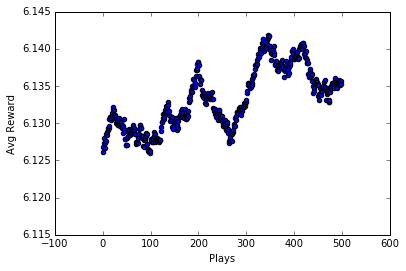

In [90]:
plt.xlabel("Plays")
plt.ylabel("Avg Reward")
for i in range(500):
    if random.random() > eps: #greedy arm selection
        choice = bestArm(av)
        thisAV = np.array([[choice, reward(arms[choice])]])
        av = np.concatenate((av, thisAV), axis=0)
    else: #random arm selection
        choice = np.where(arms == np.random.choice(arms))[0][0]
        thisAV = np.array([[choice, reward(arms[choice])]]) #choice, reward 
        av = np.concatenate((av, thisAV), axis=0) #add to our action-value memory array
    #calculate the percentage the correct arm is chosen (you can plot this instead of reward)
    percCorrect = 100*(len(av[np.where(av[:,0] == np.argmax(arms))])/len(av))
    #calculate the mean reward
    runningMean = np.mean(av[:,1])
    plt.scatter(i, runningMean)

As you can see, the average reward does indeed improve after many plays. Our algorithm is _learning_, it is getting reinforced by previous good plays! And yet it is such a simple algorithm.

I encourage you to download this notebook (scroll to bottom) and experiment with different numbers of arms and different values for $\epsilon$.

The problem we've considered here is a _stationary_ problem because the underlying reward probability distributions for each arm do not change over time. We certainly could consider a variant of this problem where this is not true, a non-stationary problem. In this case, a simple modification would be to weight more recent action-value pairs greater than distant ones, thus if things change over time, we will be able to track them. Beyond this brief mention, we will not implement this slightly more complex variant here.

In [ ]:
# incremental update the mean of a variable
def incr_mean():
    
(k+1) * M_(k+1) = k*M_k + v_(k+1)

(k+1) * M_(k+1) = (k+1) * M_k + v_(k+1) - M_k

0.9974942587


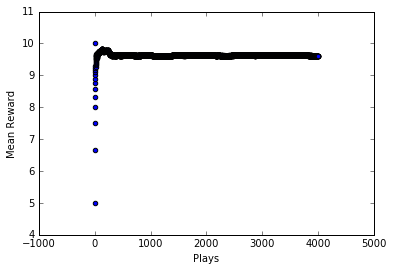

In [130]:

# define the n-armed bandit
n = 10
arms = np.random.rand(n)
def reward(prob):
    total = 0;
    for i in range(10):
        if random.random() < prob:
            total += 1
    return total

eps = 0.1
# keep a record of explorationaa
av = np.ones(n) #initialize action-value array
counts = np.zeros(n) #stores counts of how many times we've taken a particular action

#our bestArm function is much simpler now
def bestArm(a):
    return np.argmax(a) #returns index of element with greatest value
    #return np.random.choice(n,p=a)
plt.xlabel("Plays")
plt.ylabel("Mean Reward")
for i in range(4000):
    if random.random() > eps:
        # choose the best optition based on knowledge obtained so far
        choice = bestArm(av)
        counts[choice] += 1
        k = counts[choice]
        # pull the arm and get a reward
        rwd =  reward(arms[choice])
        # update our knowledge
        old_avg = av[choice]
        new_avg = old_avg + (1/k)*(rwd - old_avg) #update running avg
        av[choice] = new_avg
    else:
        choice = np.where(arms == np.random.choice(arms))[0][0] #randomly choose an arm (returns index)
        counts[choice] += 1
        k = counts[choice]
        rwd =  reward(arms[choice])
        old_avg = av[choice]
        new_avg = old_avg + (1/k)*(rwd - old_avg) #update running avg
        av[choice] = new_avg
    #have to use np.average and supply the weights to get a weighted average
    runningMean = np.average(av, weights= counts)
    plt.scatter(i, runningMean)
print max(arms)

In [128]:
arr = [1,3,5]
np.random.choice(arr,p=[0.8,0.1,0.1])

1

This method achieves the same result, getting us better and better rewards over time as it learns which lever is the best option. I had to create a separate array `counts` to keep track of how many times each action is taken to properly recalculate the running reward averages for each action. Importantly, this implementation is simpler and more memory/computationally efficient.

###Softmax Action Selection

Imagine another type of bandit problem: A newly minted doctor specializes in treating patients with heart attacks. She has 10 treatment options of which she can choose only one to treat each patient she sees. For some reason, all she knows is that these 10 treatments have different efficacies and risk-profiles for treating heart attacks, and she doesn't know which one is the best yet. We could still use our same $\epsilon$-greedy algorithm from above, however, we might want to reconsider our $\epsilon$ policy of completely randomly choosing a treatment once in awhile. In this new problem, randomly choosing a treatment could result in patient death, not just losing some money. So we really want to make sure to not choose the worst treatment but still have some ability to explore our options to find the best one.

This is where a softmax selection might be the most appropriate. Instead of just choosing an action at random during exploration, softmax gives us a probability distribution across our options. The option with the largest probability would be equivalent to our best arm action from above, but then we have some idea about what are the 2nd and 3rd best actions for example. This way, we can randomly choose to explore other options while avoiding the very worst options. Here's the softmax equation:
<div style="font-size:20px;">
$$\frac{e^{Q_k(a)/\tau}}{\sum_{i=1}^n{e^{Q_k(i)/\tau}}}$$
</div>
$\tau$ is a parameter called temperature the scales the probability distribution of actions. A high temperature will tend the probabilities to be very simmilar, whereas a low temperature will exaggerate differences in probabilities between actions. Selecting this parameter requires an educated guess and some trial and error.

When we implement the slot machine 10-armed bandit problem from above using softmax, we don't need our `bestArm()` function anymore. Since softmax produces a weighted probability distribution across our possible actions, we will just randomly (but weighted) select actions according to their relative probabilities. That is, our best action will get chosen more often because it will have the highest softmax probability, but other actions will be chosen at random at lesser frequency.

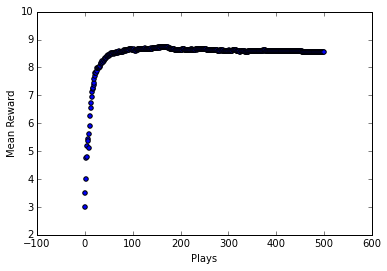

In [781]:
n = 10
arms = np.random.rand(n)

av = np.ones(n) #initialize action-value array, stores running reward mean
counts = np.zeros(n) #stores counts of how many times we've taken a particular action
#stores our softmax-generated probability ranks for each action
av_softmax = np.zeros(n)
av_softmax[:] = 0.1 #initialize each action to have equal probability

def reward(prob):
    total = 0;
    for i in range(10):
        if random.random() < prob:
            total += 1
    return total

tau = 1.12 #tau was selected by trial and error
def softmax(av):
    probs = np.zeros(n)
    for i in range(n):
        softm = ( np.exp(av[i] / tau) / np.sum( np.exp(av[:] / tau) ) )
        probs[i] = softm
    return probs

plt.xlabel("Plays")
plt.ylabel("Mean Reward")
for i in range(500):
    #select random arm using weighted probability distribution
    choice = np.where(arms == np.random.choice(arms, p=av_softmax))[0][0]
    counts[choice] += 1
    k = counts[choice]
    rwd =  reward(arms[choice])
    old_avg = av[choice]
    new_avg = old_avg + (1/k)*(rwd - old_avg)
    av[choice] = new_avg
    av_softmax = softmax(av) #update softmax probabilities for next play
        
    runningMean = np.average(av, weights=np.array([counts[j]/np.sum(counts) for j in range(len(counts))]))
    plt.scatter(i, runningMean)

Softmax action selection seems to do at least as well as epsilon-greedy, perhaps even better; it looks like it converges on an optimal policy faster. The downside to softmax is having to manually select the $\tau$ parameter. Softmax here was pretty sensitive to $\tau$ and it took awhile of playing with it to find a good value for it. Obviously with epsilon-greedy we had the parameter epsilon to set, but choosing that parameter was much more intuitive.

###Conclusion

Well that concludes Part 1 of this series. While the _n_-armed bandit problem is not all that interesting, I think it does lay a good foundation for more sophisticated problems and algorithms.

Stay tuned for part 2 where I'll cover finite Markov decision processes and some associated algorithms.

###Download this IPython Notebook
https://github.com/outlace/outlace.github.io/notebooks/rlpart1.ipynb

###References:
1. "Reinforcement Learning: An Introduction" Andrew Barto and Richard S. Sutton, 1996
2. https://en.wikipedia.org/wiki/Artificial_neural_network#History
3. https://en.wikipedia.org/wiki/Q-learning